In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, gaussian_remesh, select_LatLon, Lk_error, x_coord, y_coord
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import holoviews as hv
hvplot.output(widget_location='bottom')

In [2]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [3]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/JansenHeld', additional_subfolder='output')

In [4]:
directory = "/scratch/pp2681/mom6/Apr2023/R4-sensitivity"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [5]:
directory = "/scratch/pp2681/mom6/Apr2023/R4-change-range"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name+'-range')

In [6]:
directory = "/scratch/pp2681/mom6/Apr2023/R4-selected"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [7]:
#ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/generalization', additional_subfolder='output')

In [8]:
directory = "/scratch/pp2681/mom6/Apr2023/generalization"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [9]:
len(ds.exps)

2857

In [10]:
for exp in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R16']:
    ds.remesh('R64', exp)

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8
Experiment R64 coarsegrained to R16 is created. Its identificator=R64_R16


In [10]:
FGR=2.5
ds.remesh('R64', 'R4', f'R64_R4_FGR{FGR}', operator= lambda x,y: gaussian_remesh(x,y,FGR=FGR))
for file in [f'/scratch/pp2681/mom6/R64_R4_FGR{FGR}-part1.nc', f'/scratch/pp2681/mom6/R64_R4_FGR{FGR}-part2.nc']:
    dataset = xr.open_dataset(file, decode_times=False)
    for key in dataset.keys():
        setattr(ds[f'R64_R4_FGR{FGR}'], key, dataset[key])

Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4_FGR2.5


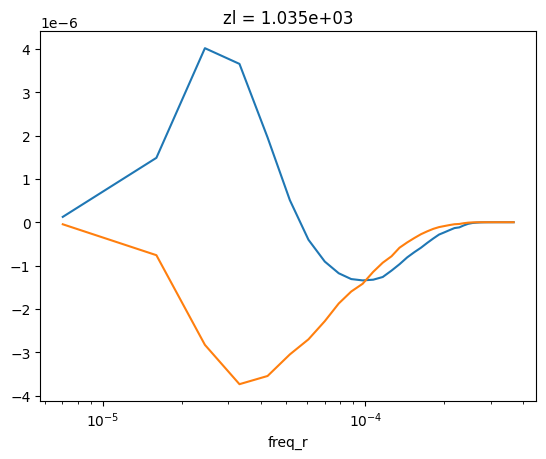

In [21]:
ds['Jansen-Held-R8-ref'].Model_transfer.isel(zl=0).plot(xscale='log')
ds['R8'].Model_transfer.isel(zl=0).plot(xscale='log')

# Momentum exchange

In [12]:
def plot_accel(exp, field = None, x=True, y=True, vmax=1.5, zonal=True, zl=0, resolved='False'):
    accel = lambda x: 1e+7*x.sel(Time=slice(365*10,None)).mean('Time').isel(zl=zl).compute()
    
    if field is None:
        if '_R' in exp:
            if zonal:
                field = ds[exp].SGSx
                field.loc[{'xq': slice(0,5), 'yh': slice(48,50)}] = 0.
            else:
                field = ds[exp].SGSy
                field.loc[{'xh': slice(0,5), 'yq': slice(48,50)}] = 0.
        elif 'GZ' in exp:
            if zonal:
                field = ds[exp].mom.CNNu+ds[exp].mom.diffu
            else:
                field = ds[exp].mom.CNNv+ds[exp].mom.diffv
        else:
            if zonal:
                field = ds[exp].mom.diffu
            else:
                field = ds[exp].mom.diffv

        if resolved == 'True':
            field = ds[exp].advection[0]
        elif resolved == 'joint':
            field = field + ds[exp].advection[0]
            
    acceleration = accel(field)
    
    print(float(acceleration.min()),float(acceleration.max()))
    im = acceleration.plot.imshow(vmin=-vmax, vmax=vmax, add_colorbar=False, cmap='seismic', interpolation='none')

    if x:
        plt.xticks((0, 5, 10, 15, 20))
        plt.xlabel('Longitude')
    else:
        plt.xticks([])
        plt.xlabel('')
        
    if y:
        plt.yticks((30, 35, 40, 45, 50))
        plt.ylabel('Latitude')
    else:
        plt.yticks([])
        plt.ylabel('')
    plt.title('')    
    plt.gca().set_aspect(1)
    
    return im

-8.378390357616551 4.449274736397129
-2.0434793462211402 3.235418794711624


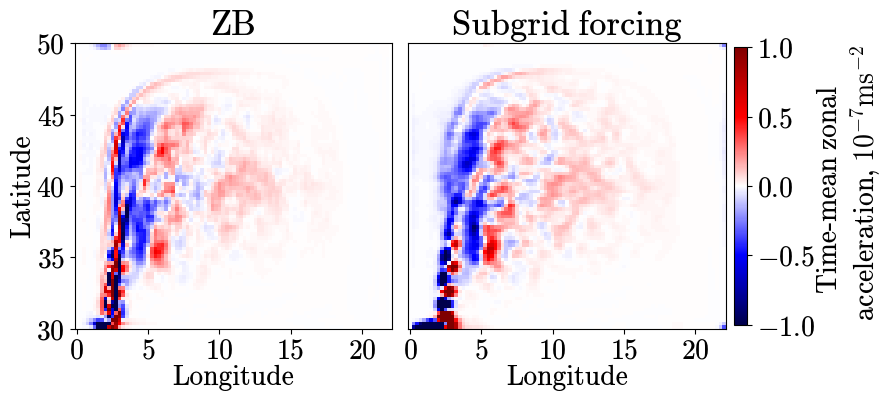

In [15]:
default_rcParams({'figure.subplot.wspace': 0.05, 'font.size':20})
plt.figure(figsize=(10,4))
plt.subplot(1,2,2)
im = plot_accel('R64_R4_FGR2.5', vmax=1, y=False)
field = ds['R64_R4_FGR2.5'].ZB_offline(amplitude=0.7)[0]
plt.title('Subgrid forcing', fontsize=25)
plt.subplot(1,2,1)
im = plot_accel('lox', vmax=1, field=field)
plt.title('ZB', fontsize=25)
cb = plt.colorbar(im, ax=plt.gcf().axes, shrink=0.9, pad=0.01)
cb.set_label(label='Time-mean zonal \n acceleration, $10^{-7} \\mathrm{m}\\mathrm{s}^{-2}$', labelpad=1, fontsize=20)
plt.savefig('site-visit/acceleration-comparison.pdf')

# Energy exchange

In [26]:
ref = ds['R64_R4_FGR2.5']
SGS = ref.SGS_transfer
def compensated(sp):
    return sp * sp.freq_r

In [27]:
ZB_offline = ref.transfer(*ref.ZB_offline(amplitude=0.7)).compute()

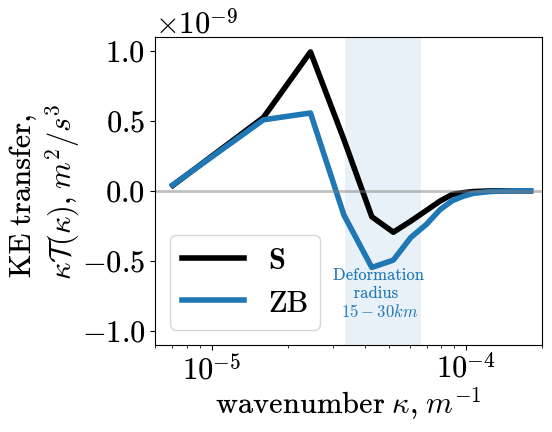

In [29]:
default_rcParams({'font.size':22, 'figure.subplot.wspace': 0.05})
zl=0
fig = plt.figure(figsize=(5,4))
compensated(SGS).isel(zl=zl).plot(color='k', lw=4, label='$\mathbf{S}$')
compensated(ZB_offline).isel(zl=zl).plot(color='tab:blue', lw=4, label='ZB')
plt.axhline(y=0,color='gray', alpha=0.5, lw=2)
plt.xlabel('wavenumber $\kappa$, $m^{-1}$')
plt.ylabel('KE transfer, \n$\kappa \mathcal{T}(\kappa)$, $m^2/s^3$')
Rd1 = 30000
Rd2 = 15000
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.ylim([-1.1e-9,1.1e-9])
plt.yticks(np.linspace(-1e-9,1e-9,5))
plt.xscale('log')
plt.text(3e-5,-0.9e-9,'Deformation \n     radius \n  $15-30km$', fontsize=12, color='tab:blue')
plt.xlim([None, 2e-4])
plt.title('')
plt.legend()
plt.savefig('site-visit/energy-exchange-ZB.pdf')

In [13]:
coarse = 'R4'
hires = 'R64'
hires_bar = 'R64_R4'
ZB = 'ZB-clean-Cs-0.06-ZB-0.5'
ZB_smooth = 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0'
ZB_reynolds = 'ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-2.0'

In [14]:
default_rcParams({'font.size': 16,'axes.formatter.limits': (-2,4), 'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.4})
def plot(idx=-1):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    im = plot_vorticity(ZB, idx=idx)
    plt.gca().set_aspect(1)
    plt.title('ZB, no filters', fontsize=25)
    plt.subplot(1,2,2)
    im = plot_vorticity(ZB_smooth, idx=idx)
    plt.gca().set_aspect(1)
    plt.ylabel('')
    plt.yticks([])
    
    plt.title('ZB, with filters', fontsize=25)
    plt.colorbar(im, ax=plt.gcf().axes, extend='both', label='Relative vorticity in \n Coriolis units, $\zeta/f$', shrink=0.99, pad=0.02)

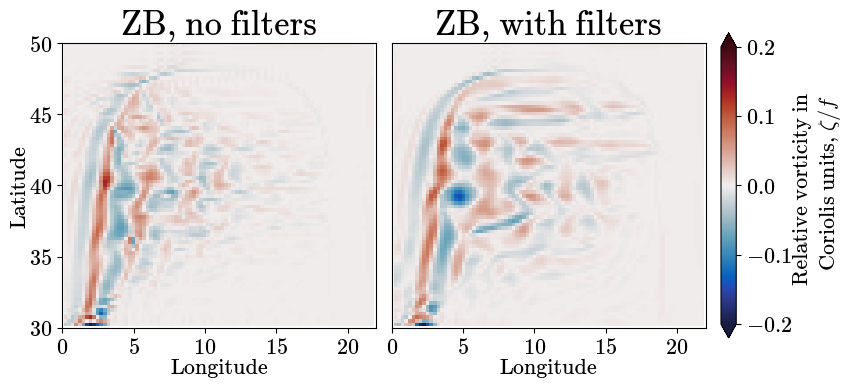

In [15]:
plot()

In [23]:
create_animation(plot, idx=range(100), filename='site-visit/filters.gif', dpi=150, deezering=True)

Animation at FPS=18 will last for 5.555555555555555 seconds


In [101]:
def plot_ssh(exp, x=True, y=True, target='R64_R4'):
    ssh = ds[exp].ssh_mean
    print(float(ssh.min()), float(ssh.max()))
    levels = np.arange(-4,4.5,0.5)
    im = ssh.plot.contourf(levels=levels, cmap='bwr', linewidths=1, vmin=-4, vmax=4, add_colorbar=False)#, cbar_kwargs={'label': 'SSH, $m$', 'ticks': [-4,-3,-2,-1,0,1,2,3,4]})
    Cplot = ssh.plot.contour(levels=levels, colors='k', linewidths=1)
    plt.gca().clabel(Cplot, Cplot.levels)
    if x:
        plt.xticks((0, 5, 10, 15, 20))
        plt.xlabel('Longitude')
    else:
        plt.xticks([])
        plt.xlabel('')
        
    if y:
        plt.yticks((30, 35, 40, 45, 50))
        plt.ylabel('Latitude')
    else:
        plt.yticks([])
        plt.ylabel('')
    plt.title('')
    if exp != target:
        RMSE = Lk_error(ds[exp].ssh_mean,ds[target].ssh_mean)[0]
        plt.text(9,31,'RMSE='+"{:.3f}".format(RMSE)+'$m$', fontsize=15)
    
    plt.gca().set_aspect(1)
    
    return im

-1.8932974338531494 1.4127191305160522
-2.003835678100586 1.3600364923477173
-2.3586008548736572 3.1677963733673096


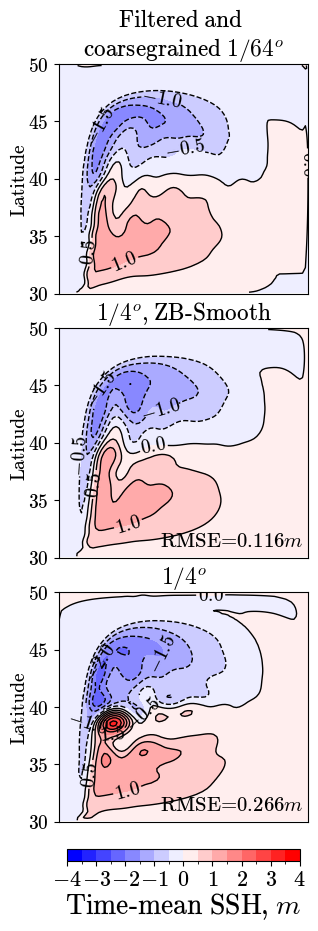

In [103]:
from matplotlib.patches import Rectangle
default_rcParams({'font.size': 14, 'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15})
plt.figure(figsize = (4,12))

target = 'R64_R4_FGR2.5'
plt.subplot(3,1,1)
im=plot_ssh(target,x=False, target=target)
plt.title('Filtered and \ncoarsegrained $1/64^o$')

plt.subplot(3,1,2)
im = plot_ssh(ZB_smooth,x=False, target=target)
plt.title('$1/4^o$, ZB-Smooth')

plt.subplot(3,1,3)
plot_ssh('R4', x=False, target=target)
plt.title('$1/4^o$')
rect = Rectangle((2, 36), 5, 5, linewidth=3, edgecolor='tab:green', facecolor='none')

cb = plt.colorbar(im, pad=0.03, ax=plt.gcf().axes, orientation='horizontal', shrink=0.75)
cb.ax.tick_params(labelsize=16)
cb.set_label(label='Time-mean SSH, $m$', fontsize=20)

plt.savefig('site-visit/ssh-bias.pdf')

# NeverWorld2

In [145]:
R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/snapshots_*', decode_times=False)
R4_smooth = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth/output/snapshots_*', decode_times=False)

In [121]:
R16f = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R16/precomputed/coarse_snapshots.nc', decode_times=False)

In [126]:
R32f = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-snapshots.nc', decode_times=False).isel(xh=slice(None,None,8), yh=slice(None,None,8)).load()
def e_to_h(e, h):
    thickness = h * 0
    
    for zl in range(len(h.zl)):
        thickness[{'zl':zl}] = e.isel(zi=zl)-e.isel(zi=zl+1)
    
    return thickness

R32f['h'] = e_to_h(R32f.e, R32f.h).compute()

In [129]:
def KEz(ds):
    return 0.5 * (ds.h * (remesh(ds.u**2, ds.h) + remesh(ds.v**2, ds.h))).sum('zl')

In [142]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.3, 'font.size': 14})
import matplotlib as mpl

def plot(idx=-1):
    plt.figure(figsize=(9,5))
    for col, (exp, label) in enumerate(
        zip(
        [R4, R4_smooth, R32f],
        ['$1/4^o$', '$1/4^o$, ZB-Smooth', '$1/32^o$ filtered to $1^o$']
        )):
        plt.subplot(1,3,col+1)
        if col==2:
            _idx = idx % 4
        else:
            _idx = idx
        KE = KEz(exp.isel(time=_idx))
        im = KE.plot.imshow(
            norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e+3),
            cmap='inferno',
            add_colorbar=False,
            interpolation='none'
        )
        plt.gca().axes.set_aspect('equal')
        plt.xlabel('')
        plt.ylabel('')
        plt.title(label, fontsize=16)
        lons = [10,30,50]
        plt.xticks(lons, [f'${lon}^o$E' for lon in lons])
        if col==0:
            lats = [-60, -40, -20, 0, 20, 40, 60]
            lat_ticks = [f'${-lat}^o$S' if lat<0 else f'${lat}^o$N' for lat in lats]
            plt.yticks(lats, lat_ticks)
        else:
            plt.yticks([])

    plt.colorbar(im, pad=0.02, ax=plt.gcf().axes, extend='both', label='Depth-integrated KE, \n$\\frac{1}{2} \\sum_k h_k (u_k^2 + v_k^2)$, $\mathrm{m}^3/\mathrm{s}^2$')

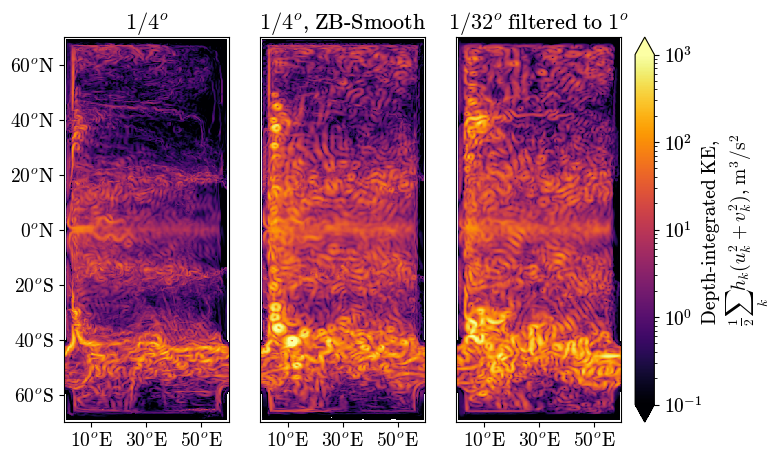

In [191]:
plot(854)

In [164]:
create_animation(plot, range(925,1000), 'site-visit/NW2.gif', deezering=False, dpi=100, FPS=15)

Animation at FPS=15 will last for 5.0 seconds


# Reference solution animation

In [12]:
def plot_vorticity(exp='R4', idx=-1):
    field = ds[exp].RV_f.isel(zl=0,Time=idx)
    im = field.plot.imshow(vmin=-0.2, vmax=0.2, cmap=cmocean.cm.balance, add_colorbar=False, interpolation='none')
    plt.xticks([0,5,10,15,20])
    plt.yticks([30,35,40,45,50])
    plt.xlim([0,22])
    plt.ylim([30,50])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('')
    return im

In [13]:
default_rcParams({'font.size': 16,'axes.formatter.limits': (-2,4), 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.4})
def plot(idx=-1):
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plot_vorticity('R4', idx=idx)
    plt.title('$1/4^o$, $24.3km$')
    plt.subplot(1,2,2)
    im = plot_vorticity('R64', idx=idx)
    plt.title('$1/64^o$, $1.5km$')
    plt.colorbar(im, ax=plt.gcf().axes, extend='both', label='Relative vorticity in \n Coriolis units, $\zeta/f$')

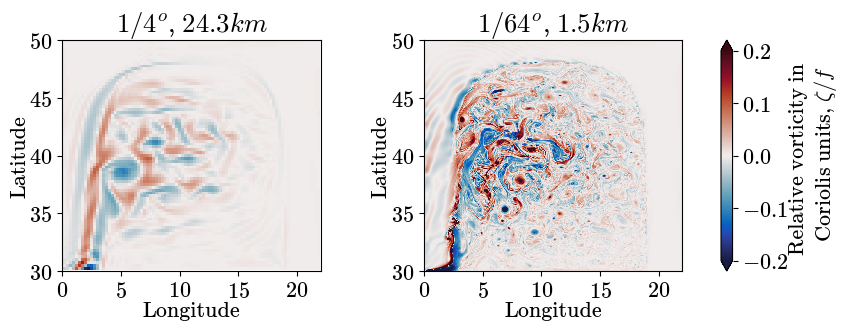

In [28]:
plot()

In [33]:
create_animation(plot, idx=range(243), filename='presentation/Reference.gif')

Animation at FPS=18 will last for 13.5 seconds


In [13]:
default_rcParams({'font.size': 16,'axes.formatter.limits': (-2,4), 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.4})
def plot(idx=-1):
    plt.figure(figsize=(10,7))
    plt.subplot(2,2,1)
    plot_vorticity('R4', idx=idx)
    plt.xlabel('')
    plt.title('$1/4^o$, $24.3km$')
    plt.subplot(2,2,2)
    im = plot_vorticity('R64_R4', idx=idx)
    plt.xlabel('')
    plt.title('$1/64^o$-Coarse')
    plt.subplot(2,2,3)
    im = plot_vorticity('GZ21-R4', idx=idx)
    plt.title('$\mathbf{CNN}$ \n(GZ2021)')
    plt.subplot(2,2,4)
    im = plot_vorticity('ZB-stress-pass-4-sel-1-Cs-0.06-ZB-0.9', idx=idx)
    plt.title('$\mathbf{Symbolic~regression}$ \n(ZB2020)')
    plt.colorbar(im, ax=plt.gcf().axes, extend='both', label='Relative vorticity in \n Coriolis units, $\zeta/f$')

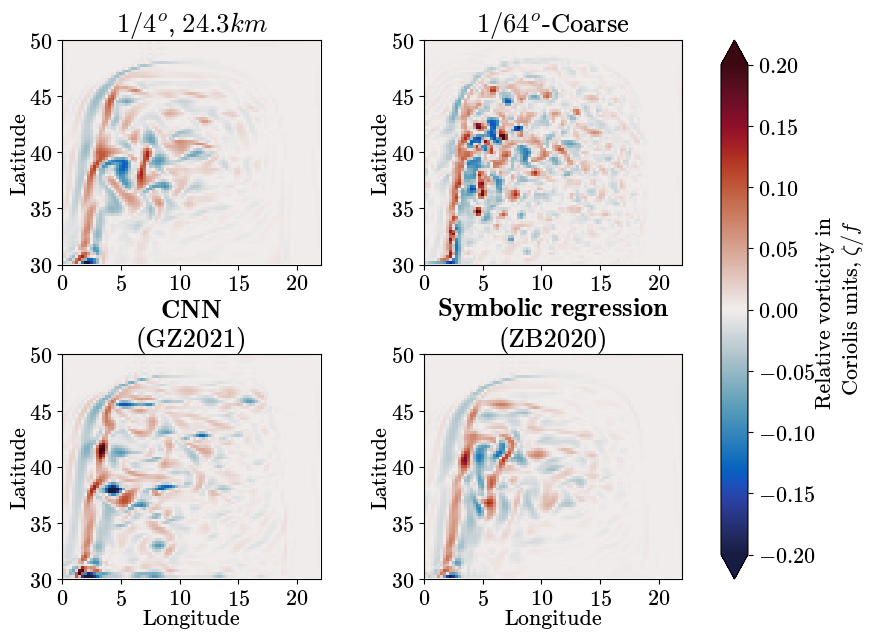

In [22]:
plot()

In [23]:
create_animation(plot, idx=range(121), filename='presentation/GZ-ZB.gif')

Animation at FPS=18 will last for 6.722222222222222 seconds


In [48]:
# (ds['R4'].logKEz.hvplot(x='xh', y='yh', cmap='inferno', clim=(-1,3), width=500, height=400) + \
# ds['GZ21-R4'].logKEz.hvplot(x='xh', y='yh', cmap='inferno', clim=(-1,3), width=500, height=400) + \
# ds['ZB-stress-pass-4-sel-1-Cs-0.06-ZB-0.9'].logKEz.hvplot(x='xh', y='yh', cmap='inferno', clim=(-1,3), width=500, height=400)).cols(2)

# Numerical noise

In [105]:
default_rcParams({'font.size': 16,'axes.formatter.limits': (-2,4), 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.4})
def plot_spectrum(zl=0, idx=-1, exps=['R4', 'ZB-clean-Cs-0.06-ZB-0.5', 'R64'], labels=['$1/4^o$', '$1/4^o$, ZB', '$1/64^o$'], colors=['tab:blue', 'tab:orange', 'k']):
    for exp,label,color in zip(exps,labels,colors):
        ds[exp].KE_spectrum_series.isel(zl=zl, Time=idx).plot(label=label,color=color,lw=2)
    plt.xlabel(r'wavenumber, $m^{-1}$')
    plt.ylabel('KE spectrum, $m^3/s^2$')
    if zl==0:
        k = [5e-5, 1e-3]
        E = [2e+2, 0]
        plt.text(2.5e-4,1e+1,'$k^{-3}$')
    else:
        k = [5e-5, 1e-3]
        E = [3e+1, 0]
        plt.text(2.5e-4,1e0,'$k^{-3}$')
    E[1] = E[0] * (k[1]/k[0])**(-3)
    plt.loglog(k,E,'--k')
    plt.title('')
    plt.ylim([1e-3,1e+4])
    plt.xlim([None,1e-3])

def plot(idx=-1):
    plt.figure(figsize=(14,3))
    plt.subplot(1,3,1)
    plot_spectrum(idx=idx)
    plt.legend(fontsize=14, ncol=2, loc='center', bbox_to_anchor=(0.5,1.17))
    plt.subplot(1,3,2)
    plot_vorticity('R4', idx=idx)
    plt.title('$1/4^o$')
    plt.subplot(1,3,3)
    im = plot_vorticity('ZB-clean-Cs-0.06-ZB-0.5', idx=idx)
    plt.title('$1/4^o$, ZB')
    plt.colorbar(im, ax=plt.gcf().axes, extend='both', label='Relative vorticity in \n Coriolis units, $\zeta/f$')

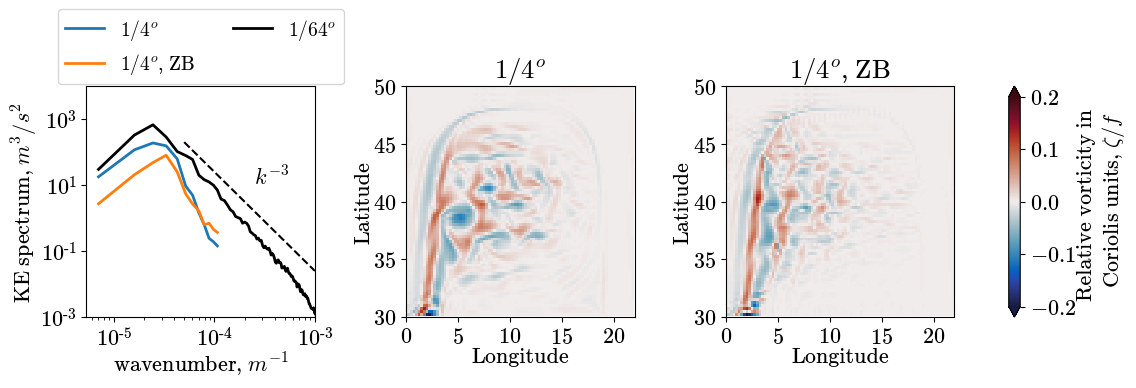

In [118]:
plot(idx=-1)

# Parameterized models

In [235]:
default_rcParams({'font.size': 16,'axes.formatter.limits': (-2,4), 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.4})
def plot(idx=-1):
    plt.figure(figsize=(12,6))
    for j, (exp, label) in enumerate(zip([coarse, ZB, ZB_ssd, hires_bar, ZB_smooth, ZB_reynolds], ['$1/4^o$', '$1/4^o$, ZB', '$1/4^o$, ZB-Ssd', '$1/64^o$-Coarse', '$1/4^o$, ZB-Smooth', '$1/4^o$, ZB-Reynolds'])):
        plt.subplot(2,3,j+1)
        im = plot_vorticity(exp, idx=idx)
        plt.title(label)
        if j<4:
            plt.xlabel('')
    plt.colorbar(im, ax=plt.gcf().axes, extend='both', label='Relative vorticity in \n Coriolis units, $\zeta/f$')

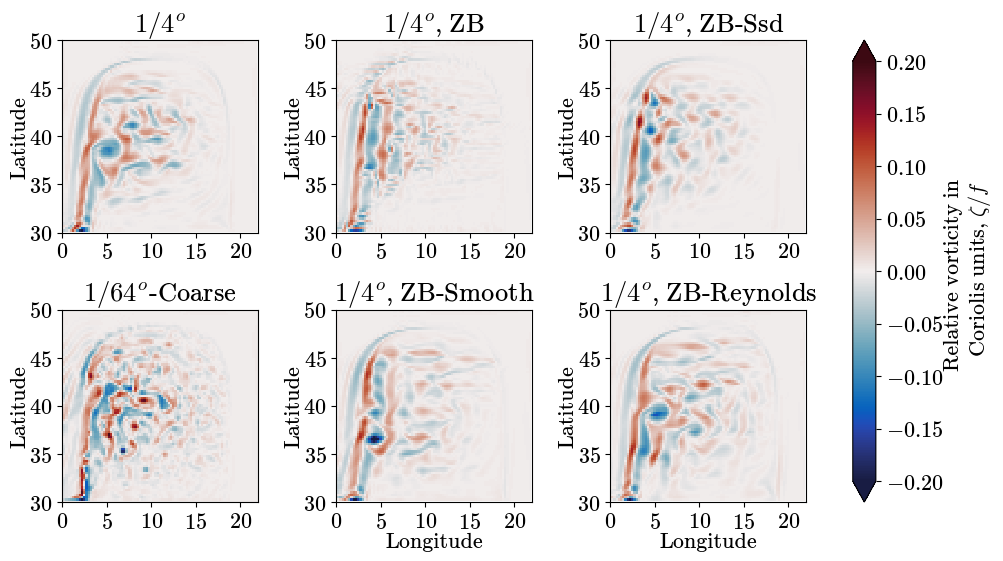

In [236]:
plot()

In [237]:
create_animation(plot, idx=range(243), filename='presentation/ZB_regularized.gif', FPS=18)

Animation at FPS=18 will last for 13.5 seconds


# Defining main models for comparison

In [213]:
coarse = 'R4'
hires = 'R64'
hires_bar = 'R64_R4'
ZB = 'ZB-clean-Cs-0.06-ZB-0.6'
ZB_ssd = 'ZB-ssd-5-R4-ZB-0.6'
ZB_smooth = 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-0.9'
ZB_reynolds = 'ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-2.2'

In [214]:
labeling = {
'coarse': '$1/4^o$',
'hires': '$1/64^o$',
'hires_bar': '$1/64^o$-Coarse',
'ZB': '$1/4^o$, ZB',
'ZB_ssd': '$1/4^o$, ZB-Ssd',
'ZB_smooth': '$1/4^o$, ZB-Smooth',
'ZB_reynolds': '$1/4^o$, ZB-Reynolds'
}

# Figure second. KE spectrum

In [215]:
exps = [ZB, ZB_ssd, ZB_smooth, ZB_reynolds, coarse, hires]
labels = [labeling[key] for key in ['ZB', 'ZB_ssd', 'ZB_smooth', 'ZB_reynolds', 'coarse', 'hires']]
colors = ['tab:blue', 'tab:red', [0.9290, 0.6940, 0.1250], [0.4940, 0.1840, 0.5560], 'k', 'k']
lws = [2.0]*4 + [1.5, 1.5]
lss = ['-', '-', '-', '-', '-.', '-']

In [216]:
def plot_spectrum(zl=0):
    for exp,label,color,lw,ls in zip(exps,labels,colors,lws,lss):
        ds[exp].EKE_spectrum.isel(zl=zl).plot(label=label,color=color,lw=lw,ls=ls)
    plt.xlabel(r'wavenumber, $m^{-1}$')
    plt.ylabel('EKE spectrum, $m^3/s^2$')
    if zl==0:
        k = [5e-5, 5e-4]
        E = [1.5e+2, 0]
        plt.text(1.5e-4,2e+1,'$k^{-3}$')
    else:
        k = [5e-5, 5e-4]
        E = [3e+1, 0]
        plt.text(1.5e-4,2e0,'$k^{-3}$')
    E[1] = E[0] * (k[1]/k[0])**(-3)
    plt.loglog(k,E,'--k')
    plt.title('')
    plt.ylim([1e-5,1e+3])
#    plt.xlim([None,1e-3])

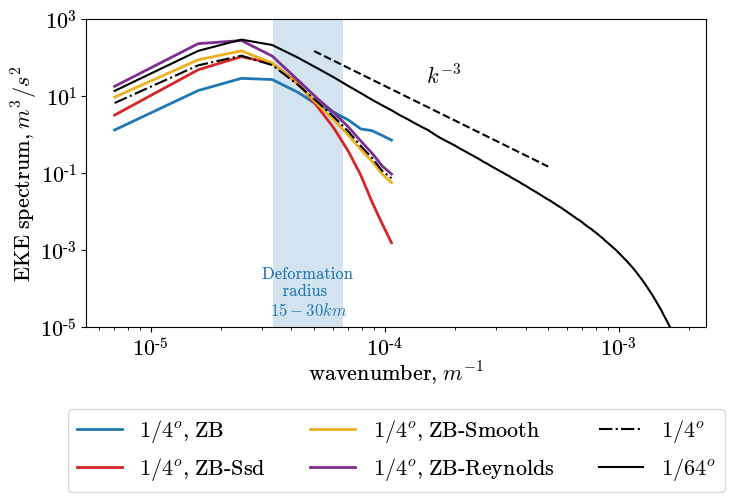

In [217]:
default_rcParams({'font.size': 16})
plt.figure(figsize=(8,4))
plt.subplot(1,1,1)
plot_spectrum()
plt.legend(ncol=3, bbox_to_anchor=(0.5,-0.4), loc='center')
# Baroclinic deformation radius
Rd1 = 30000
Rd2 = 15000
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.text(3e-5,2e-5,'Deformation \n     radius \n  $15-30km$', fontsize=12, color='tab:blue')
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.savefig('presentation/Spectrum.pdf')

# Figure 3. Offline vs Online transfer and power spectrum.

In [ ]:
# ZB = 'ZB-clean-Cs-0.06-ZB-0.5'
# ZB_smooth = 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-0.9'
# ZB_reynolds = 'ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-2.8'

In [218]:
ref = ds['R64_R4']
SGS = ref.SGS_transfer
ZB_offline = ref.transfer(*ref.ZB_offline(amplitude=0.6)[0]).compute()
ZB_smooth_offline = ref.transfer(*ref.ZB_offline(amplitude=0.9, Stress_iter=4)[0]).compute()
ZB_reynolds_offline = ref.transfer(*ref.ZB_offline(amplitude=2.2, Stress_iter=4, HPF_iter=4)[0]).compute()

In [219]:
Smagorinsky_offline = ref.transfer(*ref.Smagorinsky(Cs=0.06)).compute()

In [220]:
labels = ['ZB', 'ZB-Ssd', 'ZB-Smooth', 'ZB-Reynolds']
colors = ['tab:blue', 'tab:red', [0.9290, 0.6940, 0.1250], [0.4940, 0.1840, 0.5560]]

In [221]:
def compensated(sp):
    return sp * sp.freq_r

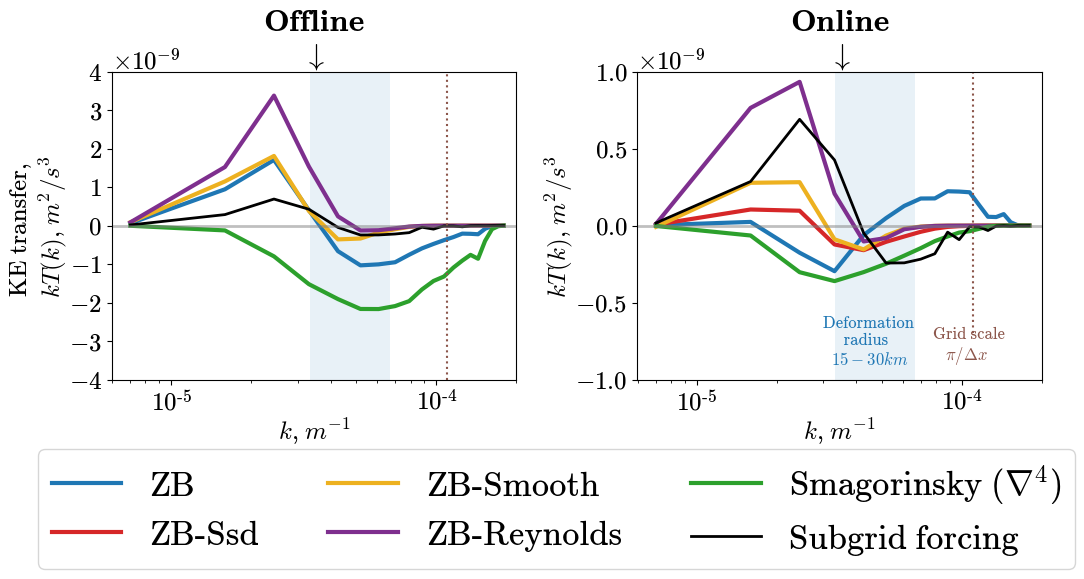

In [222]:
default_rcParams({'font.size':18, 'figure.subplot.hspace': 0.45})
zl=0
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
compensated(ZB_offline).isel(zl=zl).plot(lw=3, label=labels[0], color=colors[0])
compensated(ZB_smooth_offline).isel(zl=zl).plot(lw=3, label=labels[1], color=colors[2])
compensated(ZB_reynolds_offline).isel(zl=zl).plot(lw=3, label=labels[2], color=colors[3])
compensated(Smagorinsky_offline).isel(zl=zl).plot(lw=3, label=labels[1], color='tab:green')
compensated(SGS).isel(zl=zl).plot(color='k', lw=2, label='Subgrid forcing')
plt.axhline(y=0,color='gray', alpha=0.5, lw=2)
plt.xlabel('$k$, $m^{-1}$')
plt.ylabel('KE transfer, \n$kT(k)$, $m^2/s^3$')
plt.title('Offline\n$\downarrow$', fontweight='bold', y=1.)
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.ylim([-4e-9,4e-9])
plt.yticks(np.linspace(-4e-9,4e-9,9))
plt.xscale('log')
plt.axvline(x=1.1e-4, ls=':', color='tab:brown')
plt.xlim([None, 2e-4])

plt.subplot(1,2,2)
for exp,label,color in zip([ZB, ZB_ssd, ZB_smooth, ZB_reynolds],labels,colors):
    compensated(ds[exp].ZB_transfer).isel(zl=zl).plot(lw=3, label=label,color=color)
compensated(ds['R4'].Smagorinsky_transfer).isel(zl=zl).plot(lw=3, label='Smagorinsky ($\\nabla^4$)', color='tab:green')
compensated(SGS).isel(zl=zl).plot(color='k', lw=2, label='Subgrid forcing')
plt.axhline(y=0,color='gray', alpha=0.5, lw=2)
plt.xlabel('$k$, $m^{-1}$')
plt.ylabel('$kT(k)$, $m^2/s^3$')
plt.ylim([-1e-9,1e-9])
plt.yticks(np.linspace(-1e-9,1e-9,5))
plt.xscale('log')
plt.xlim([None, 2e-4])
plt.title('Online\n$\downarrow$', fontweight='bold', y=1.)
plt.legend(bbox_to_anchor=(-0.2,-0.42), loc='center', ncol=3, fontsize=25)
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.text(3e-5,-0.9e-9,'Deformation \n     radius \n  $15-30km$', fontsize=12, color='tab:blue')
plt.axvline(x=1.1e-4, ls=':', color='tab:brown', ymin=0.15)
plt.text(0.78e-4, -0.87e-9, 'Grid scale\n   $\\pi/\\Delta x$', fontsize=12, color='tab:brown')

plt.savefig('presentation/SGS_spectrum.pdf')

# Figure KE_PE

In [223]:
exps = [coarse, ZB, ZB_ssd, ZB_smooth, ZB_reynolds, hires_bar]
labels = ['$1/4^o$', 'ZB', 'ZB-Ssd', 'ZB-Smooth', 'ZB-Reynolds', '$1/64^o$-Coarse']

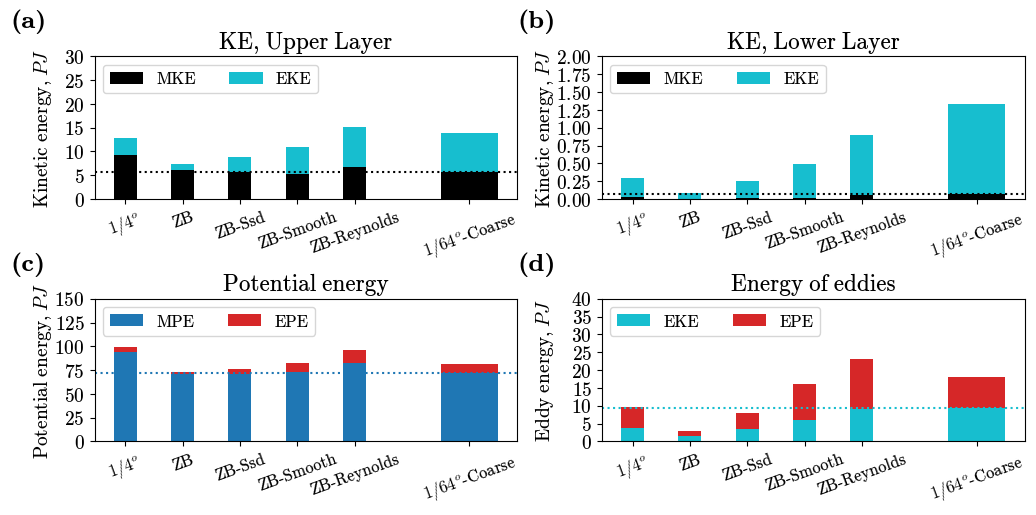

In [224]:
default_rcParams()#{'font.size':18, 'figure.subplot.hspace': 0.45})
ds.plot_KE_PE(exps, labels, rotation=20)
set_letters(y=1.2, fontsize=18)
plt.gcf().align_ylabels()
plt.savefig('presentation/KE_PE.pdf')

# Figure ssh

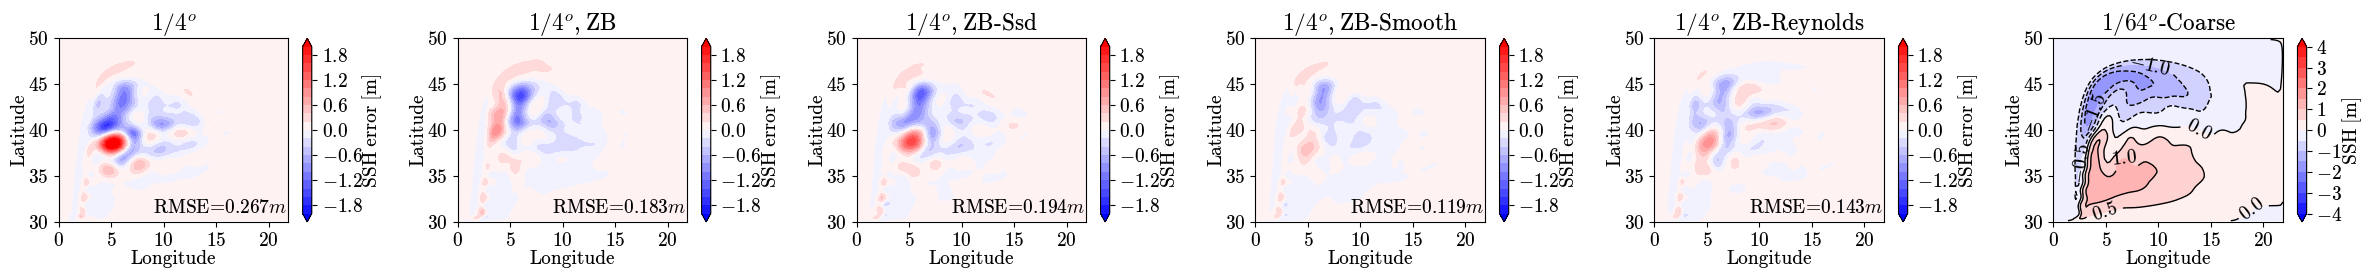

In [210]:
exps = [coarse, ZB, ZB_ssd, ZB_smooth, ZB_reynolds, hires_bar] 
labels = [labeling[key] for key in ['coarse', 'ZB', 'ZB_ssd', 'ZB_smooth', 'ZB_reynolds', 'hires_bar']]
ds.plot_ssh(exps,labels=labels, target='R64_R4')

In [225]:
def plot_ssh(exp):
    ssh = ds[exp].ssh_mean
    print(float(ssh.min()), float(ssh.max()))
    levels = np.arange(-4,4.5,0.5)
    im = ssh.plot.contourf(levels=levels, cmap='bwr', linewidths=1, vmin=-4, vmax=4, add_colorbar=False)#, cbar_kwargs={'label': 'SSH, $m$', 'ticks': [-4,-3,-2,-1,0,1,2,3,4]})
    Cplot = ssh.plot.contour(levels=levels, colors='k', linewidths=1)
    plt.gca().clabel(Cplot, Cplot.levels)
    plt.xticks((0, 5, 10, 15, 20))
    plt.yticks((30, 35, 40, 45, 50))
    plt.xlabel('')
    plt.ylabel('')
    plt.title('')
    if exp != 'R64_R4':
        RMSE = Lk_error(ds[exp].ssh_mean,ds['R64_R4'].ssh_mean)[0]
        plt.text(8.5,31,'RMSE='+str(round(RMSE,3))+'$m$', fontsize=14)
    
    return im
def plot_error(exp, target=hires_bar):
    ssh = ds[exp].ssh_mean
    ssh = ssh - remesh(ds[target].ssh_mean,ssh)
    print(float(ssh.min()), float(ssh.max()))
    levels = np.linspace(-3,3,31)
    ssh.plot.contourf(levels=levels, cmap='bwr', linewidths=1, vmin=-3, vmax=3, cbar_kwargs={'label': 'SSH error, $m$', 'ticks': [-3,-2,-1,0,1,2,3]})
    plt.xticks((0, 5, 10, 15, 20))
    plt.yticks((30, 35, 40, 45, 50))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('')

-2.4356021881103516 1.4054086208343506
-2.0779480934143066 1.4221857786178589
-2.3586008548736572 3.1677963733673096
-1.9788780212402344 1.3930447101593018
-2.3085482120513916 1.6091119050979614
-1.9260118007659912 1.437463402748108


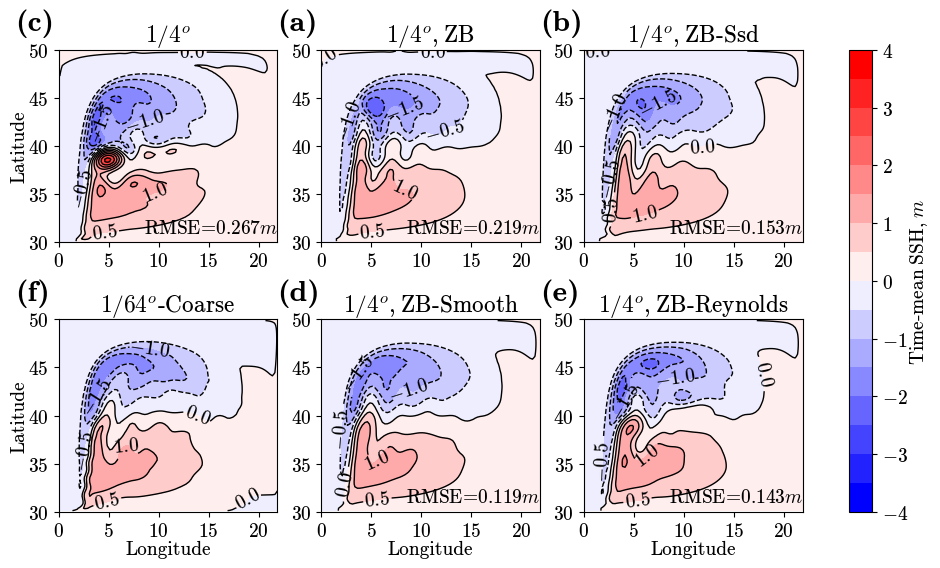

In [226]:
default_rcParams({'font.size': 14, 'figure.subplot.wspace': 0.2, 'figure.subplot.hspace': 0.4})
plt.figure(figsize = (12,6))

plt.subplot(2,3,2)
plot_ssh(ZB)
plt.title(labeling['ZB'])

plt.subplot(2,3,3)
plot_ssh('ZB-ssd-5-R4-ZB-0.6')
plt.title(labeling['ZB_ssd'])

plt.subplot(2,3,1)
plot_ssh(coarse)
plt.title(labeling['coarse'])
plt.ylabel('Latitude')

plt.subplot(2,3,5)
plot_ssh(ZB_smooth)
plt.title(labeling['ZB_smooth'])
plt.xlabel('Longitude')

plt.subplot(2,3,6)
plot_ssh(ZB_reynolds)
plt.title(labeling['ZB_reynolds'])
plt.xlabel('Longitude')

#ax = plt.gcf().add_axes([0.7,0.35,0.3,0.35])
plt.subplot(2,3,4)
im=plot_ssh(hires_bar)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(labeling['hires_bar'])
plt.colorbar(im, label='Time-mean SSH, $m$', ax=plt.gcf().axes)

set_letters(fontsize=20, y=1.1)

plt.savefig('presentation/ssh.pdf')

# Generalization

In [256]:
def error_total_energy(exp, target):
    return sum(ds[exp].Lk_error(ds[target], features=['EKE_joul', 'MKE_joul', 'EPE_joul', 'MPE_joul', 'EPE_ssh', 'MPE_ssh'], normalize=False)[0])*1e-15



In [257]:
def error_energy(exp, target):
    return sum(ds[exp].Lk_error(ds[target], features=['EKE_joul', 'MKE_joul'], normalize=False)[0])*1e-15


In [258]:
def error_ssh(exp, target):
    return Lk_error(ds[exp].ssh_mean,ds[target].ssh_mean)[0]

In [259]:
def generalization_error(prefix='ZB-clean', fun=error_total_energy, confs=['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']):
    ZB = sorted([float(exp.split('-')[-1]) for exp in ds.exps if f'{prefix}-R4' in exp])
#    print(ZB)
    error = xr.DataArray(np.zeros((len(confs), len(ZB))), dims=['res', 'ZB'])
    for i, conf in enumerate(confs):
        for j, zb in enumerate(ZB):
            try:
                error[i,j] = fun(f'{prefix}-{conf}-ZB-{zb}', f'R64_{conf}')
            except:
                error[i,j] = np.nan
    error['ZB'] = ZB
    return error

In [271]:
def plot_generalization(kind='ssh', models=['ZB-clean', 'ZB-ssd', 'ZB-Smooth'], labels=['ZB', 'ZB-Hypervisc', 'ZB-Smooth']):
    if kind =='ssh':
        fun = error_ssh
        def yaxis():
            plt.yticks(np.arange(0,0.50,0.05))
            plt.ylim([0,0.5])
        def ylabel():
            plt.ylabel('RMSE in \ntime-mean SSH, $m$')
    elif kind=='total-energy':
        fun = error_total_energy
        def yaxis():
            plt.yticks(np.arange(0,85,5))
            plt.ylim([0,85])
        def ylabel():
            plt.ylabel('Error in \nEKE, MKE, EPE, MPE, $PJ$')
    elif kind=='kinetic-energy':
        fun = error_energy
        def yaxis():
            plt.yticks(np.arange(0,16,1))
            plt.ylim([0,16])
        def ylabel():
            plt.ylabel('Error in \nEKE, MKE, $PJ$')

    
    default_rcParams()
    bare = [fun(conf,f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']]
    error = {}
    for model in models:
        error[model] = generalization_error(model, fun=fun)

    import matplotlib.colors as mcolors
    plt.figure(figsize=(6,6))
    
    for col, model in enumerate(models):
        plt.subplot(1,len(models),col+1)
        e = error[model]
        for ZB in e.ZB:
            e.sel(ZB=ZB).plot(label=float(ZB), marker='o')
        plt.plot(bare, color='k', marker='o')
        plt.xticks([0,1,2,3,4,5,6], ['$1/2^o$', '$1/3^o$', '$1/4^o$', '$1/5^o$', '$1/6^o$', '$1/7^o$', '$1/8^o$'],rotation=50)
        if col==0:
            ylabel()
        yaxis()
        plt.grid()
        plt.legend(title='$-\\frac{\kappa_{BC}}{\Delta x ~ \Delta y}$', fontsize=10)
        plt.title(labels[col])
        plt.xlabel('')

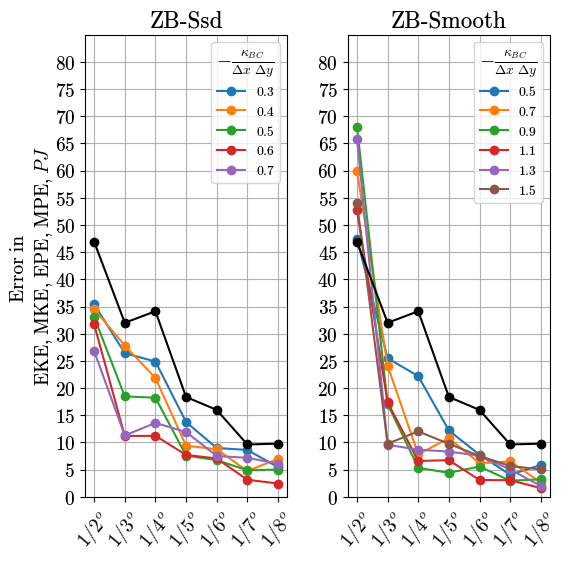

In [272]:
plot_generalization('total-energy', models=['ZB-ssd-5', 'ZB-Smooth'], labels=['ZB-Ssd', 'ZB-Smooth'])
plt.savefig('presentation/generalization.pdf')

# Define error functions to be used for sensitivity plots

In [239]:
def error_ssh(exp):
    return Lk_error(ds[exp].ssh_mean,ds['R64_R4'].ssh_mean)[0]

In [240]:
def error_ssh_std(exp):
    return Lk_error(ds[exp].ssh_std,ds['R64_R4'].ssh_std)[0]

In [241]:
def error_spectrum(exp):
    return Lk_error(ds[exp].EKE_spectrum, ds['R64_R4'].EKE_spectrum)[0]

In [242]:
def error_spectrum_large(exp):
    return Lk_error(ds[exp].EKE_spectrum[:,0:3], ds['R64_R4'].EKE_spectrum[:,0:3])[0]

In [243]:
def error_energy(exp):
    return sum(ds[exp].Lk_error(ds['R64_R4'], features=['EKE_joul', 'MKE_joul'], normalize=False)[0]) * 1e-15

In [244]:
def error_total_energy(exp):
    return sum(ds[exp].Lk_error(ds['R64_R4'], features=['EKE_joul', 'MKE_joul', 'EPE_joul', 'MPE_joul', 'EPE_ssh', 'MPE_ssh'], normalize=False)[0]) * 1e-15

# Plotter for 2D sensitivity

In [245]:
def error_2d(error_function = error_ssh, prefix='ZB-clean'):
    if f'{prefix}-Cs-{0.03}-ZB-{7.0}' in ds.exps:
        ZBs = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0]
    elif f'{prefix}-Cs-{0.03}-ZB-{28.0}' in ds.exps:
        ZBs = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]
    elif f'{prefix}-Cs-{0.03}-ZB-{4.4}' in ds.exps:
        ZBs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0]
    elif f'{prefix}-Cs-{0.03}-ZB-{2.4}' in ds.exps:
        ZBs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]
    else:
        ZBs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
    error = np.zeros((len(ZBs), 3))
    for i, Cs in enumerate([0.03,0.06,0.09]):
        for j, ZB in enumerate(ZBs):
            try:
                error[j,i] = error_function(f'{prefix}-Cs-{Cs}-ZB-{ZB}')
            except:
                error[j,i] = 1e+10
    error = xr.DataArray(error, dims=['ZB', 'Cs'], coords={'Cs': [0.03,0.06,0.09], 'ZB': ZBs})
    return error

In [246]:
ssh = {'v0': 0.26709399, 'vmin': 0.0, 'error_function': error_ssh, 
       'color': 'w', 'cbar_ticks': np.arange(0.0,0.7,0.05), 
       'cbar_extend': 'neither', 'cbar_label': 'RMSE in \ntime-mean SSH, $m$'};
ssh_std = {'v0': 0.086690746, 'vmin': 0.0, 'error_function': error_ssh_std, 
           'color': 'k', 'cbar_ticks': np.arange(0,0.2,0.02), 
           'cbar_extend': 'max', 'cbar_label': 'RMSE in \nstandard deviation of SSH, $m$'};
sp = {'v0': 64.31411662832397, 'vmin': 0.0, 'error_function': error_spectrum, 
       'color': 'w', 'cbar_ticks': np.arange(0,140,10), 
       'cbar_extend': 'neither', 'cbar_label': 'RMSE in \nEKE spectrum, $m^3/s^2$'};

sp_large = {'v0': 99.26127116294647, 'vmin': 0.0, 'error_function': error_spectrum_large, 
       'color': 'w', 'cbar_ticks': np.arange(0,200,10), 
       'cbar_extend': 'neither', 'cbar_label': 'RMSE in \nEKE spectrum, $m^3/s^2$'};

energy = {'v0': 9.1115783207157, 'vmin': 0.0, 'error_function': error_energy, 
          'color': 'w', 'cbar_ticks': np.arange(0,20),
          'cbar_extend': 'neither', 'cbar_label': 'Error in \nEKE and MKE, $PJ$'}

tot_energy = {'v0': 34.13488452735518, 'vmin': 0.0, 'error_function': error_total_energy, 
          'color': 'w', 'cbar_ticks': np.arange(0,80,5),
          'cbar_extend': 'neither', 'cbar_label': 'Error in \nEKE, MKE, EPE, MPE, $PJ$'}

In [247]:
def constrain_optimization(e):
    #shape of e is ZB x Cs
    ee = e.copy()
    for j in range(e.shape[1]):
        for i in range(e.shape[0]):
            if e[i,j] == 1e+10:
                ee[i:,j] = 1e+10
    return ee    

In [248]:
def plot_panels(exps, labels, v0, vmin, error_function, color='w', cbar_ticks=None, cbar_extend='none', cbar_label=''):
    default_rcParams({})
    fig = plt.figure(figsize=(3*len(exps),4))
    vspread = v0-vmin
    vmax = v0+vspread

    for col in range(len(exps)):
        label=labels[col]
        exp=exps[col]
        plt.subplot(1,len(exps),col+1)
        e = error_2d(error_function = error_function, prefix=exp)
        im = e.plot(cmap='RdBu_r', add_colorbar=False, vmin=vmin, vmax=vmax)
        cb = plt.colorbar(im, fraction=0.3, pad=0.05, aspect=15, ticks=cbar_ticks, extend=cbar_extend)
        cb.set_label(cbar_label, fontsize=20)
        if col<len(exps)-1:
            #cb.ax.set_yticklabels(['']*len(cbar_ticks))
            cb.set_label('')
            
        idx_opt = constrain_optimization(e).argmin(dim='ZB')
        markers = ['v', 'o', 's']
        for marker, Cs in zip(markers,idx_opt.Cs):
            idx = idx_opt.sel(Cs=Cs)
            plt.plot(Cs,e.ZB[idx], marker=marker, markeredgecolor=color, markerfacecolor='none', markersize=10, markeredgewidth=2)
            cb.ax.plot(0.5,e.sel(Cs=Cs).isel(ZB=idx),marker=marker,markeredgecolor=color, markerfacecolor='none', markersize=10, markeredgewidth=2)
        plt.plot(0.06,0,marker='p',markeredgecolor='k', markerfacecolor='none', markersize=10, markeredgewidth=2)
        cb.ax.plot(0.5,e[0,1],marker='p',markeredgecolor='k', markerfacecolor='none', markersize=10, markeredgewidth=2)

        plt.xticks([0.03, 0.06, 0.09], [0.03, 0.06, 0.09], rotation=60)
        plt.xlabel('')
        if col==0:
            plt.ylabel('ZB scaling coefficient, \n$-\kappa_{BC} / (\Delta x ~ \Delta y)$', fontsize=20)
#            plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]);
        else:
            plt.ylabel('')
 #           plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5], ['']*16);
        plt.yticks(e.ZB.values)
        plt.title(label)
    fig.text(0.5, -0.1, 'Smagorinsky coefficient $C_S$', ha='center', fontsize=20)
    

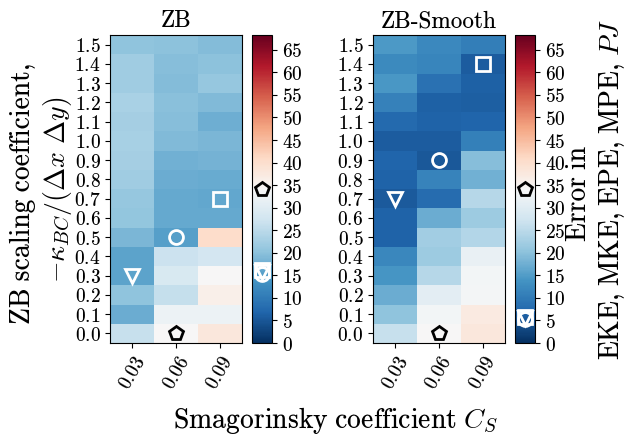

In [255]:
plot_panels(['ZB-clean', 'ZB-stress-pass-4-sel-1'], labels=['ZB', 'ZB-Smooth'], **tot_energy)
plt.savefig('presentation/sensitivity.pdf')

# Additional plots

In [9]:
def plot_spectrum(exps=[],zl=0, colors=[None]*5+['k'], lws=[1.5]*8, lss=['-']*8, labels=['$1/4^o$', '$1/5^o$', '$1/6^o$', '$1/7^o$', '$1/8^o$', 'High \nres.']):
    for exp,label,color,lw,ls in zip(exps,labels,colors,lws,lss):
        ds[exp].EKE_spectrum.isel(zl=zl).plot(label=label,color=color,lw=lw,ls=ls)
    plt.xlabel(r'wavenumber, $m^{-1}$')
    plt.ylabel('EKE spectrum, $m^3/s^2$')
    if zl==0:
        k = [5e-5, 5e-4]
        E = [1.5e+2, 0]
        plt.text(1.5e-4,2e+1,'$k^{-3}$')
    else:
        k = [5e-5, 5e-4]
        E = [3e+1, 0]
        plt.text(1.5e-4,2e0,'$k^{-3}$')
    E[1] = E[0] * (k[1]/k[0])**(-3)
    plt.loglog(k,E,'--k')
    plt.title('')
    plt.xlim([None,3e-4])
    plt.yticks([1e-3,1e-2,1e-1,1e0,1e+1,1e+2, 1e+3])
    plt.ylim([1e-3,1e+3])
    Rd1 = 30000
    Rd2 = 15000
    plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)


In [10]:
default_rcParams({'figure.subplot.wspace': 0.4, 'font.size': 18})

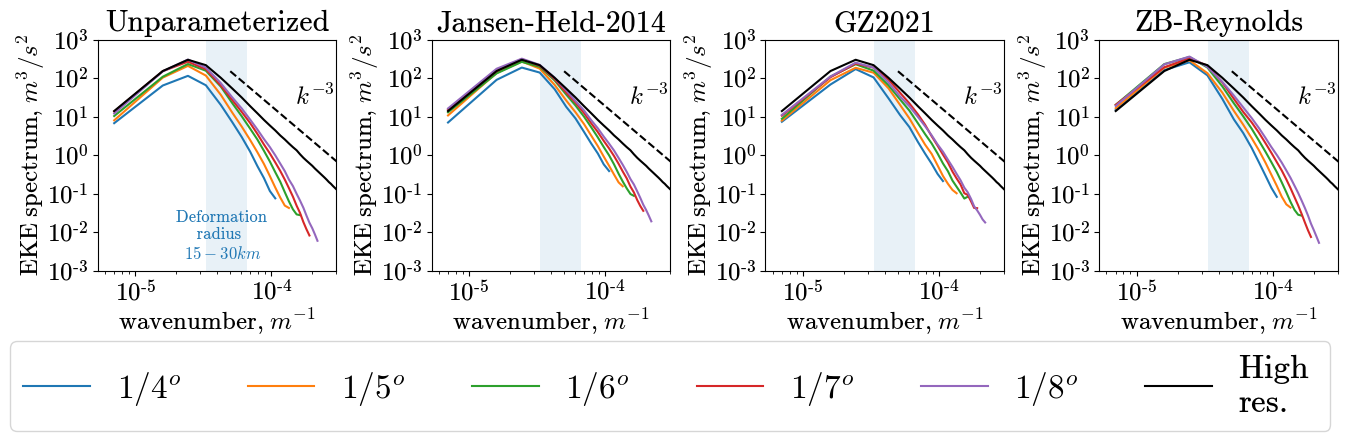

In [11]:
plt.figure(figsize=(16,3))
plt.subplot(1,4,1)
plot_spectrum([f'R{n}' for n in range(4,9)]+['R64'])
plt.title('Unparameterized')
plt.text(2e-5,2e-3,'Deformation \n     radius \n  $15-30km$', fontsize=12, color='tab:blue')

plt.subplot(1,4,2)
plot_spectrum([f'Jansen-Held-R{n}-ref' for n in range(4,9)]+['R64'])
plt.title('Jansen-Held-2014')

plt.subplot(1,4,3)
plot_spectrum([f'GZ21-R{n}' for n in range(4,9)]+['R64'])
plt.title('GZ2021')

plt.subplot(1,4,4)
plot_spectrum([f'ZB-Reynolds-R{n}-ZB-1.8' for n in range(4,9)]+['R64'])
plt.title('ZB-Reynolds')
plt.legend(ncol=6, loc='center', bbox_to_anchor=(-1.8,-0.5), fontsize=24)
#plt.savefig('presentation/spectrum_comparison.pdf')

In [53]:
def plot_ssh(exp):
    ssh = ds[exp].ssh_mean
    print(float(ssh.min()), float(ssh.max()))
    levels = np.arange(-4,4.5,0.5)
    im = ssh.plot.contourf(levels=levels, cmap='bwr', linewidths=1, vmin=-4, vmax=4, add_colorbar=False)#, cbar_kwargs={'label': 'SSH, $m$', 'ticks': [-4,-3,-2,-1,0,1,2,3,4]})
    Cplot = ssh.plot.contour(levels=levels, colors='k', linewidths=1)
    plt.gca().clabel(Cplot, Cplot.levels)
    plt.xticks((0, 5, 10, 15, 20))
    plt.yticks((30, 35, 40, 45, 50))
    plt.xlabel('')
    plt.ylabel('')
    plt.title('')
    if exp != 'R64_R4':
        RMSE = Lk_error(ds[exp].ssh_mean,ds['R64_R4'].ssh_mean)[0]
        plt.text(8.5,31,'RMSE='+str(round(RMSE,3))+'$m$', fontsize=14)
    return im

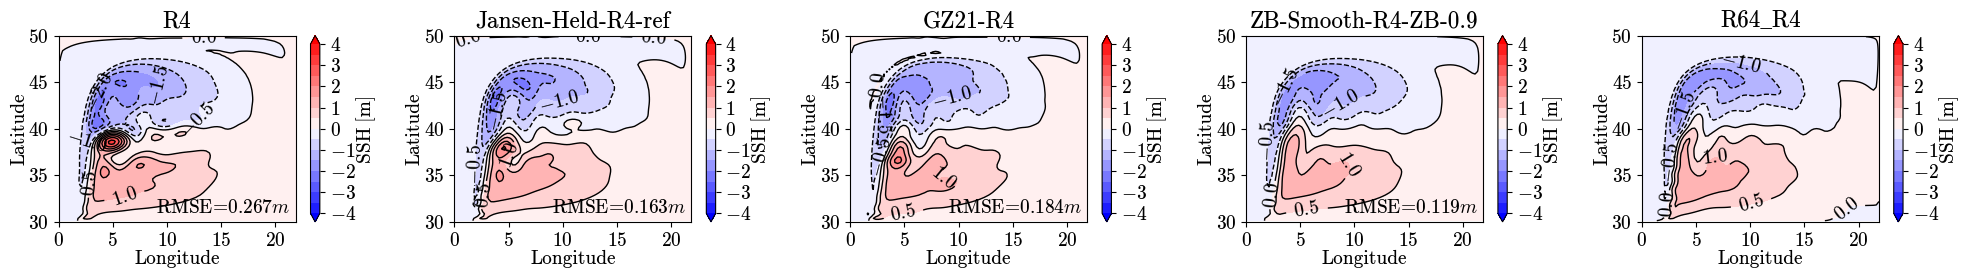

In [108]:
default_rcParams({})
ds.plot_ssh(['R4', 'Jansen-Held-R4-ref', 'GZ21-R4', 'ZB-Smooth-R4-ZB-0.9', 'R64_R4'])

-2.3586008548736572 3.1677963733673096
-2.25085186958313 2.0608599185943604
-2.324131727218628 2.1559622287750244
-1.9260118007659912 1.437463402748108
-1.9788780212402344 1.3930447101593018


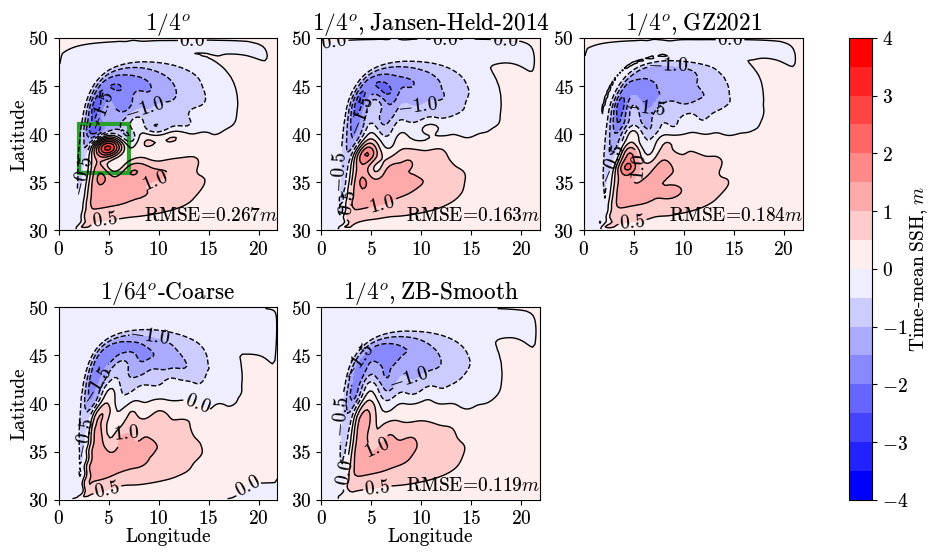

In [109]:
from matplotlib.patches import Rectangle
default_rcParams({'font.size': 14, 'figure.subplot.wspace': 0.2, 'figure.subplot.hspace': 0.4})
plt.figure(figsize = (12,6))

plt.subplot(2,3,1)
plot_ssh('R4')
plt.title('$1/4^o$')
plt.ylabel('Latitude')
rect = Rectangle((2, 36), 5, 5, linewidth=3, edgecolor='tab:green', facecolor='none')
plt.gca().add_patch(rect)

plt.subplot(2,3,2)
plot_ssh('Jansen-Held-R4-ref')
plt.title('$1/4^o$, Jansen-Held-2014')

plt.subplot(2,3,3)
plot_ssh('GZ21-R4')
plt.title('$1/4^o$, GZ2021')

plt.subplot(2,3,4)
im=plot_ssh('R64_R4')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('$1/64^o$-Coarse')

plt.subplot(2,3,5)
im = plot_ssh('ZB-Smooth-R4-ZB-0.9')
plt.title('$1/4^o$, ZB-Smooth')
plt.xlabel('Longitude')

plt.colorbar(im, label='Time-mean SSH, $m$', ax=plt.gcf().axes)
plt.savefig('presentation/ssh_comparison.pdf')

-2.3586008548736572 3.1677963733673096
-1.9260118007659912 1.437463402748108
-2.324131727218628 2.1559622287750244
-1.9788780212402344 1.3930447101593018


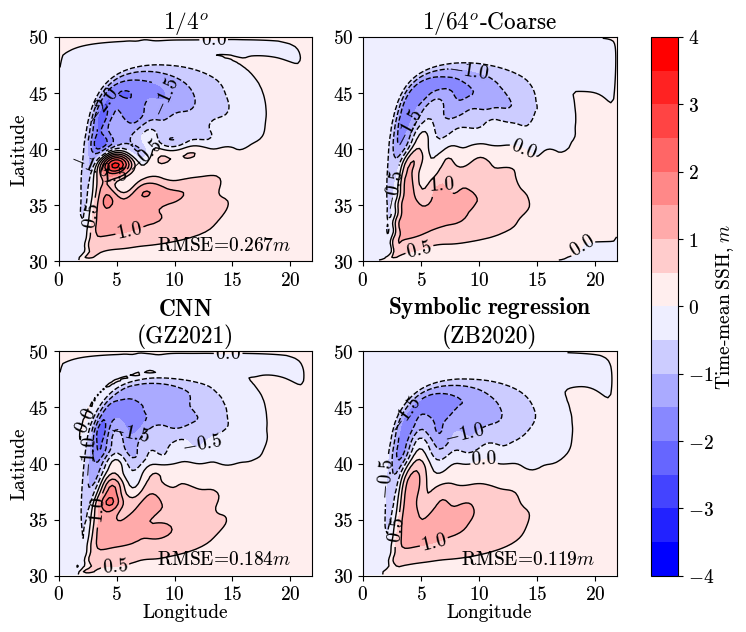

In [59]:
default_rcParams({'font.size': 14, 'figure.subplot.wspace': 0.2, 'figure.subplot.hspace': 0.4})
plt.figure(figsize = (9,7))

plt.subplot(2,2,1)
plot_ssh('R4')
plt.title('$1/4^o$')
plt.ylabel('Latitude')

plt.subplot(2,2,2)
im=plot_ssh('R64_R4')
plt.title('$1/64^o$-Coarse')

plt.subplot(2,2,3)
plot_ssh('GZ21-R4')
plt.title('$\mathbf{CNN}$ \n(GZ2021)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(2,2,4)
im = plot_ssh('ZB-Smooth-R4-ZB-0.9')
plt.title('$1/4^o$, ZB-Smooth')
plt.xlabel('Longitude')
plt.title('$\mathbf{Symbolic~regression}$ \n(ZB2020)')

plt.colorbar(im, label='Time-mean SSH, $m$', ax=plt.gcf().axes)
plt.savefig('presentation/ssh_comparison_crop.pdf')

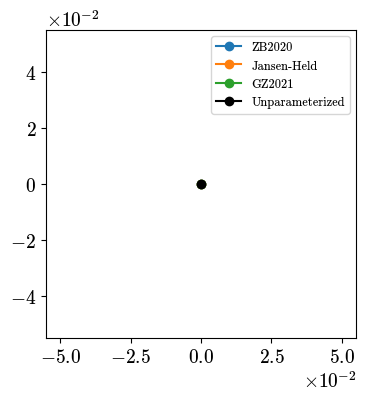

In [72]:
plt.plot(0,0, marker='o', label='ZB2020')
plt.plot(0,0, marker='o', label='Jansen-Held')
plt.plot(0,0, marker='o', label='GZ2021')
plt.plot(0,0, marker='o', label='Unparameterized', color='k')
plt.legend(fontsize=9)
plt.savefig('presentation/legend.pdf')

In [96]:
def error_total_energy(exp, target):
    return sum(ds[exp].Lk_error(ds[target], features=['EKE_joul', 'MKE_joul', 'EPE_joul', 'MPE_joul', 'EPE_ssh', 'MPE_ssh'], normalize=False)[0])*1e-15
def error_potential_energy(exp, target):
    return sum(ds[exp].Lk_error(ds[target], features=['EPE_joul', 'MPE_joul', 'EPE_ssh', 'MPE_ssh'], normalize=False)[0])*1e-15
def error_energy(exp, target):
    return sum(ds[exp].Lk_error(ds[target], features=['EKE_joul', 'MKE_joul'], normalize=False)[0])*1e-15
def error_mean_energy(exp, target):
    return sum(ds[exp].Lk_error(ds[target], features=['MKE_joul', 'MPE_joul', 'MPE_ssh'], normalize=False)[0])*1e-15
def error_eddy_energy(exp, target):
    return sum(ds[exp].Lk_error(ds[target], features=['EKE_joul', 'EPE_joul', 'EPE_ssh'], normalize=False)[0])*1e-15
def error_ssh(exp, target):
    return Lk_error(ds[exp].ssh_mean,ds[target].ssh_mean)[0]
def error_ssh_std(exp, target):
    return Lk_error(ds[exp].ssh_std, ds[target].ssh_std)[0]

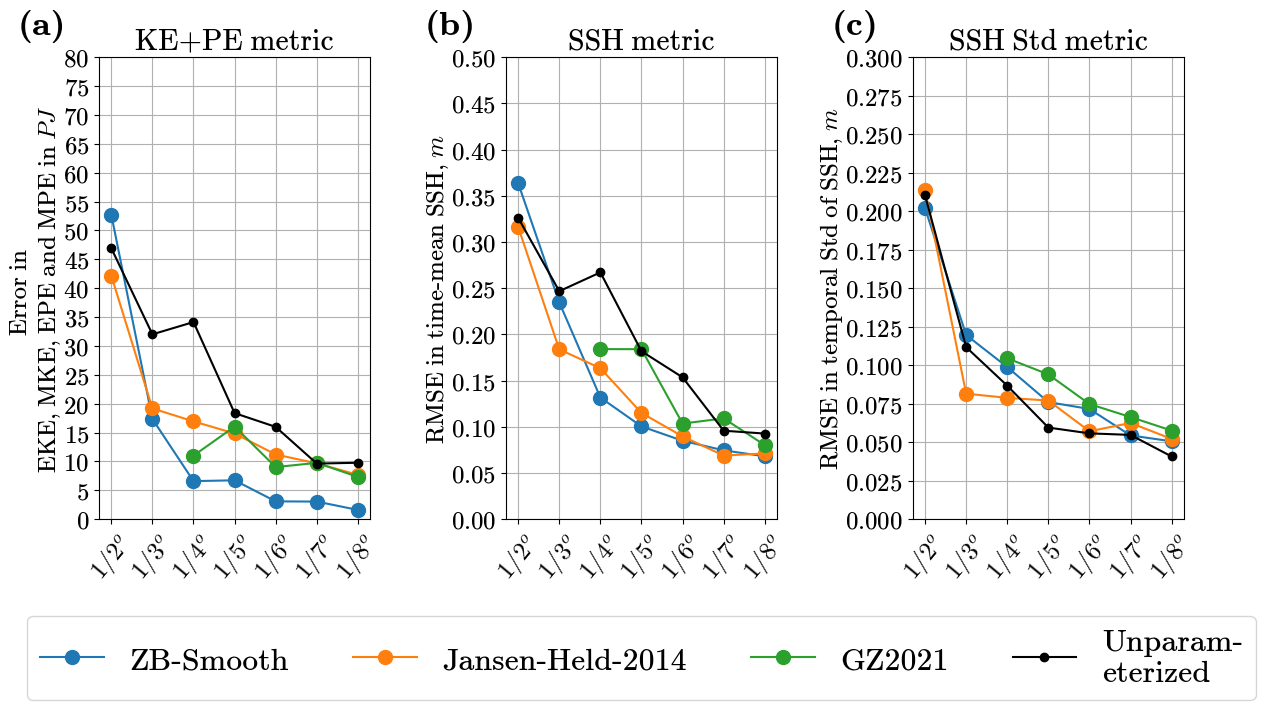

In [106]:
default_rcParams({'figure.subplot.wspace': 0.5, 'font.size': 18})
plt.figure(figsize=(14,6))

ZBs = [0.3, 0.6, 1.1, 1.8]

ylabels = [
    'Error in \nEKE, MKE, EPE and MPE in $PJ$',
    'RMSE in time-mean SSH, $m$',
    'RMSE in temporal Std of SSH, $m$'
]
for col, fun in enumerate([error_total_energy, error_ssh, error_ssh_std]):
    plt.subplot(1,3,col+1)
    error = {}
    error['bare'] = [fun(conf,f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']]
    error['ZB-Smooth'] = [fun(f'ZB-Smooth-{conf}-ZB-1.1', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']]
    error['Jansen-Held'] = [fun(f'Jansen-Held-{conf}-ref', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']]
    error['GZ'] = [np.nan, np.nan] + [fun(f'GZ21-{conf}', f'R64_{conf}') for conf in ['R4', 'R5', 'R6', 'R7', 'R8']]
    
    
    plt.plot(error['ZB-Smooth'], marker='o', markersize=10, label='ZB-Smooth')
    plt.plot(error['Jansen-Held'], marker='o', markersize=10, label='Jansen-Held-2014')
    plt.plot(error['GZ'], marker='o', markersize=10, label='GZ2021')
    plt.plot(error['bare'], color='k', marker='o', label='Unparam-\neterized')
    
    plt.ylim([0,None])
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^o$', '$1/3^o$', '$1/4^o$', '$1/5^o$', '$1/6^o$', '$1/7^o$', '$1/8^o$'],rotation=50)    
    
    
    if fun == error_ssh:
        plt.yticks(np.arange(0,0.55,0.05))
        plt.ylim([0,0.5])
        plt.ylabel('RMSE in time-mean SSH, $m$')
        plt.title('SSH metric')
    if fun == error_ssh_std:
        plt.yticks(np.arange(0,0.325,0.025))
        plt.ylim([0,0.3])
        plt.ylabel('RMSE in temporal Std of SSH, $m$')
        plt.title('SSH Std metric')
    if fun == error_energy:
        plt.yticks(np.arange(0,16,1))
        plt.ylim([0,15])
        plt.ylabel('Error in \nEKE, MKE in $PJ$')
        plt.title('KE metric')
    if fun == error_total_energy:
        plt.yticks(np.arange(0,90,5))
        plt.ylim([0,80])
        plt.ylabel('Error in \nEKE, MKE, EPE and MPE in $PJ$')
        plt.title('KE+PE metric')
    
    plt.grid()
    
    if col==0:
        plt.legend(loc='center', bbox_to_anchor=(2,-0.3), ncol=4, fontsize=23)
set_letters(fontsize=24, x=-0.3)
plt.savefig('presentation/generalization_comparison.pdf')

# Offline 

In [121]:
ref = ds['R64_R4']
SGS = ref.SGS_transfer
ZB_offline = ref.transfer(*ref.ZB_offline(amplitude=0.242)[0]).compute()

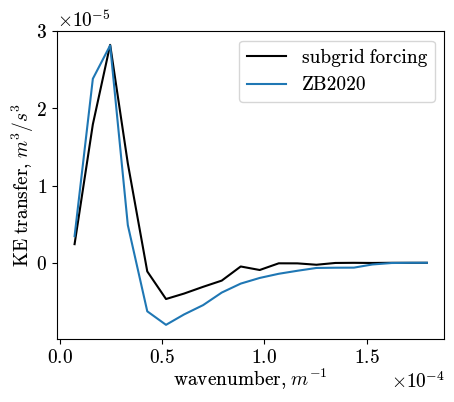

In [129]:
default_rcParams()
plt.figure(figsize=(5,4))
SGS.isel(zl=0).plot(color='k', label='subgrid forcing')
ZB_offline.isel(zl=0).plot(label='ZB2020')
plt.xlabel('wavenumber, $m^{-1}$')
plt.ylabel('KE transfer, $m^3/s^3$')
plt.title('')
plt.legend()
plt.savefig('presentation/Offline_ZB_only.pdf')

# Subgrid forcing dataset

In [31]:
for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R16']:
    dataset = xr.Dataset()
    for key in ['u', 'v', 'SGSx', 'SGSy']:
        dataset[key] = ds[f'R64_{conf}'].__getattribute__(key).compute().astype('float32')
        print(conf, key)
    dataset.to_netcdf(f'/scratch/pp2681/mom6/subgrid_forcing_R64/{conf}.nc')

R2 u
R2 v
R2 SGSx
R2 SGSy
R3 u
R3 v
R3 SGSx
R3 SGSy
R4 u
R4 v
R4 SGSx
R4 SGSy
R5 u
R5 v
R5 SGSx
R5 SGSy
R6 u
R6 v
R6 SGSx
R6 SGSy
R7 u
R7 v
R7 SGSx
R7 SGSy
R8 u
R8 v
R8 SGSx
R8 SGSy
R16 u
R16 v
R16 SGSx
R16 SGSy


In [42]:
def get(conf='R4', key='u', time=-1, zl=0):
    return xr.open_dataset(f'/scratch/pp2681/mom6/subgrid_forcing_R64/{conf}.nc')[key].isel(Time=time,zl=zl)

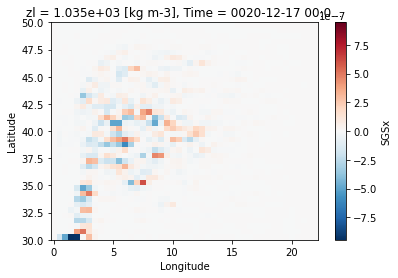

In [51]:
get('R2','SGSx',zl=0).plot()